<a href="https://colab.research.google.com/github/jnpos/group8_ECG/blob/Development/ECG_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!git clone https://github.com/jveenland/tm10007_ml.git

fatal: destination path 'tm10007_ml' already exists and is not an empty directory.


In [10]:
# General packages
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics
import zipfile
import os
import pandas as pd

# Metrics
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn import preprocessing

In [11]:
with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')



The number of samples: 827
The number of columns: 9001


**Split input, output, test and train data:**

In [17]:
# Find column with label 
bool_cols = [col for col in data 
             if np.isin(data[col].dropna().unique(), [0, 1]).all()]
loc_label = data.columns.get_loc('label')

# Determine data and output 
y = data['label']
x = pd.DataFrame()
x = data.drop(data.columns[loc_label],axis=1)

# Split test and trainingsdata 
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y,test_size=0.25,random_state=0,stratify=y)


<class 'pandas.core.frame.DataFrame'>


**Scaling:**

In [21]:
# SCALEN
scaler = preprocessing.RobustScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train))

<class 'pandas.core.frame.DataFrame'>


**PCA:**

In [22]:
# PCA
n_samples = len(x_train)
n_features = len(x_train.columns)
n_features = min((n_samples-1), n_features)
print(n_features)

p = PCA(n_components=n_features)
p = p.fit(x_train)
x_pca = p.transform(x_train)

print(f'result pca: {x_pca.shape}')

619
result pca: (620, 619)


**Feature selection:**

In [49]:
# Feature selection

# Univariate & f_classif
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif,k="all")
selector.fit(x_pca,y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

dataframe = pd.DataFrame()
dataframe = selector.pvalues_

print(len(selector.pvalues_[selector.pvalues_<0.05]))

fs = SelectKBest(score_func=f_classif, k=len(selector.pvalues_[selector.pvalues_<0.05]))
X_univariate = fs.fit_transform(x_pca, y_train)
print(f'result univariate: {X_univariate.shape}')

# Elastic net
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel

ENreg = ElasticNet(alpha=1, l1_ratio=0.5).fit(x_pca,y_train)
model_ENreg = SelectFromModel(ENreg, prefit=True)
x_ENreg = model_ENreg.transform(x_pca)

print(f'result Elastic Net: {x_ENreg.shape}')

#x_ENreg = pd.DataFrame(x_ENreg)


36
result univariate: (620, 36)
result Elastic Net: (620, 13)


**Learning curves:**

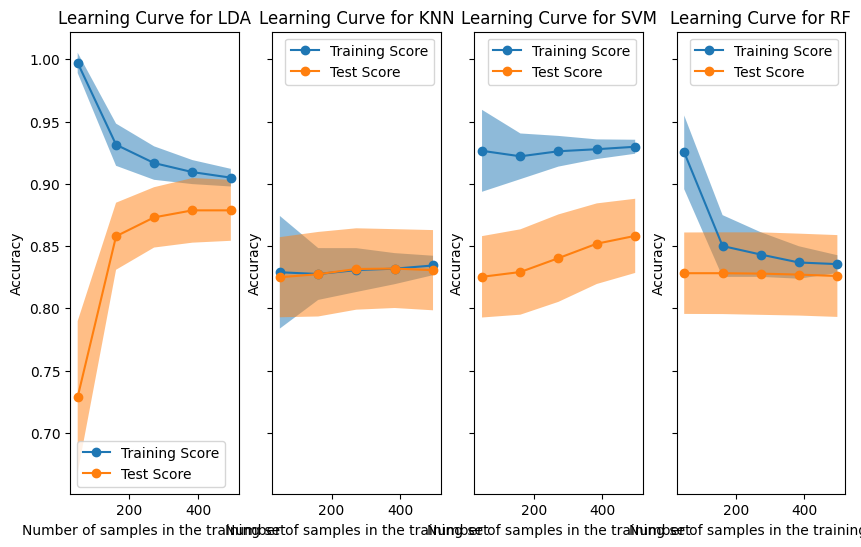

In [31]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
neigh = KNeighborsClassifier(n_neighbors=10)
svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))
rf = RandomForestClassifier(max_depth=2, random_state=0)


import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_univariate,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}
title = ['LDA', 'KNN', 'SVM', 'RF']

for ax_idx, estimator in enumerate([lda, neigh, svc, rf]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {title[ax_idx]}")